# Predicting Cardiovascular Disease: A Data-Driven Risk Assessment

## 1. Introduction 

Cardiovascular disease (CVD) is the leading cause of death globally, accounting for million deaths per year. Early identification of at-risk individuals can lead to timely intervention and save lives.  We can do this with data science, as we analyze a dataset with statistics that can indicate if someone has cardiovascular disease.  In our dataset, we collect stats and characteristics of thousands of patients.  We will use various classification algorithms (logistic regression, and ) to train on this data, and predict if someone is going to develop cardiovascular disease just from their characteristics.  

In this project, we analyze patient health metrics to:
- Understand key risk factors
- Build a predictive model for cardiovascular disease
- Provide actionable recommendations for healthcare decision-makers

This type of data work can directly assist health clinics, telemedicine providers, or insurance companies in managing population health more effectively.

Let's look at what columns the data has...


In [1]:
import pandas as pd
import numpy as np

heart_df = pd.read_csv('cardio_train.csv', delimiter = ';')

# number of rows
print("Number of patients in dataset: "+str(len(heart_df)))

heart_df.head(10)

Number of patients in dataset: 70000


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,0
7,12,22584,2,178,95.0,130,90,3,3,0,0,1,1
8,13,17668,1,158,71.0,110,70,1,1,0,0,1,0
9,14,19834,1,164,68.0,110,60,1,1,0,0,0,0


We use an anonymized dataset of 70000 patient records, which have the following columns of data:

`age`, `gender` (1 male, 2 female), `height` (lbs), `weight` (inches), `ap_hi` (systolic BP), `ap_lo` (diastolic BP), `cholesterol`, `gluc`, `smoke`, `alco`, `active`, `cardio` (target: 1 = has cardiovascular disease, 0 = healthy)

The goals in this dataset will be to...

- Perform exploratory data analysis (EDA)  
- Identify top risk factors using visualization and feature importance  
- Train and evaluate classification models (Logistic Regression, Random Forest)  
- Translate findings into real-world policy recommendations

First let us represent the data with graphs to see what what kind of people we are dealing with in this dataset, then we will prepare it for predictions. 


## 2. Data Exploration

As always, with any kaggle dataset, we need to prepare and clean the data to help optimize visualizing the data.  In the next function **cleaner_df**, we will convert the `age` column into years (it is for sure being reported as days alive), and remove duplicates and NaNs.

In [3]:

def cleaner_df(df, map_names):
    
    df.columns = [col.capitalize() for col in df.columns]
    
    # remap column names
    df = df.rename(columns = {'Ap_hi':'Systolic BP', 'Ap_lo':'Diastolic BP', 'Gluc':'Glucose',
                              'Alco':'Alcohol Drinker', 'Active':'Exerciser', 'Smoke': 'Smoker'
                              'Cardio':'CVD'})
    
    # create new column 
    df['Age'] = (df['Age'] / 365).astype(int)
    
    # there are no NaNs in this dataset, but I would count them and deal with them another way
    df = df.dropna()
    
    # in case there are some weird bloodpressure readings that could be errors
    df = df[(df['Systolic BP'] > 60) & (df['Systolic BP'] < 220)]
    df = df[(df['Diastolic BP'] > 30) & (df['Diastolic BP'] < 140)]
    
    # create a BMI category
    df['BMI'] = df['Weight'] / (df['Height']/100)**2
    
    # make category columns for cholestorol and glucose
    df['Cholesterol Category'] = df['Cholesterol'].map(map_names)
    df['Glucose Category'] = df['Glucose'].map(map_names)

    # Check for missing data
    print("Missing values per column:\n", df.isna().sum())
    
    print("Total number of data points after cleaning: "+str(len(df)))
    
    return df

MAP_NAMES = {1: 'Normal', 2: 'Above Normal', 3: 'Well Above'}

clean_heart_df = cleaner_df(heart_df, MAP_NAMES)


Missing values per column:
 Id                      0
Age                     0
Gender                  0
Height                  0
Weight                  0
Systolic BP             0
Diastolic BP            0
Cholesterol             0
Glucose                 0
Smoker                  0
Alcohol Drinker         0
Exerciser               0
Cardio                  0
BMI                     0
Cholesterol Category    0
Glucose Category        0
dtype: int64
Total number of data points after cleaning: 68691


Before performing any analysis or modeling, we cleaned the data to ensure quality and interpretability:

- **Converted age from days to years** for human-readable analysis. The original `age` column is in days, so we created a new column `age_years = age / 365`.

- **Calculated BMI** using height and weight to explore body composition as a factor:  
  `BMI = weight / (height in meters)^2`
  
- **Dropped duplicate entries** to avoid overrepresenting patients in the analysis.

- **Filtered out extreme blood pressure readings** (e.g., systolic < 80 or > 240) to reduce noise from erroneous inputs.

- **Mapped cholesterol and glucose codes** to readable categories:  
  `1 = normal`, `2 = above normal`, `3 = well above normal`

We also verified that there were **no missing values** in the dataset.  Due to the blood pressure filter we put in, 1307 data points were removed from the set.

Now we introduce our first graph, which is a stacked histogram showing the number of people that have cardiovascular disease 

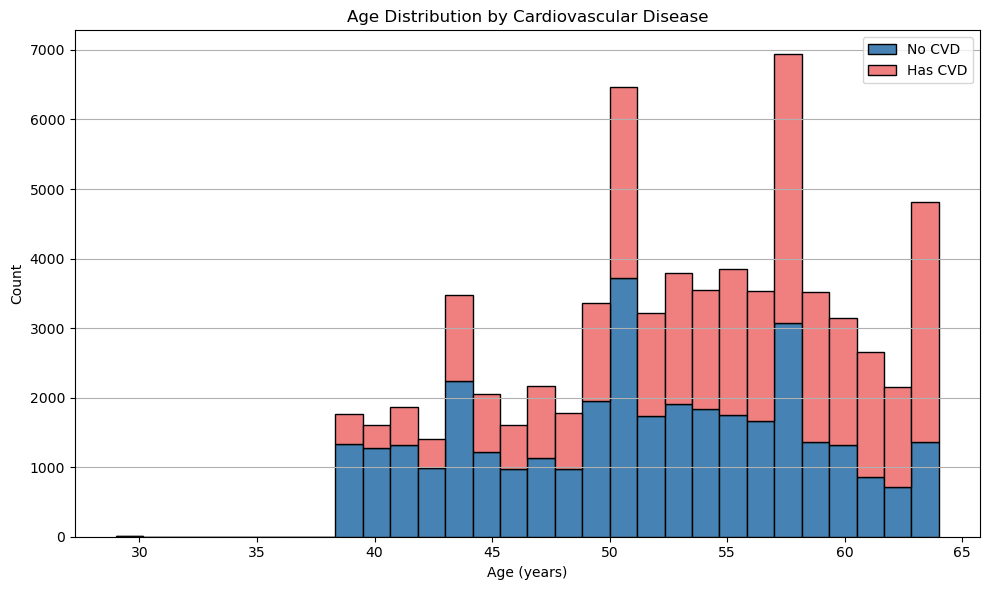

In [3]:
import matplotlib.pyplot as plt

def plot_age_histogram(df):
    plt.figure(figsize=(10, 6))
    
    # Split age groups
    age_no_cvd = df[df['CVD'] == 0]['Age']   # i do not have cardiovascular disease
    age_cvd = df[df['CVD'] == 1]['Age']      # i do have cardiovascular disease
    
    # Plot stacked histogram
    plt.hist([age_no_cvd, age_cvd], bins=30, stacked=True,
             label=['No CVD', 'Has CVD'], color=['steelblue', 'lightcoral'], edgecolor='black')
    
    plt.title('Age Distribution by Cardiovascular Disease')
    plt.xlabel('Age (years)')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()
    
plot_age_histogram(clean_heart_df)

This stacked histogram displays the age distribution of patients, separated by cardiovascular disease status:

- **Blue bars** represent patients **without** cardiovascular disease (CVD).

- **Red bars** represent patients **with** cardiovascular disease.

The x-axis shows age in years (converted from days in the original dataset), and the y-axis shows the **count of patients** in each age group.

Insights...

- The majority of patients are between **40 and 65 years old**.

- The incidence of cardiovascular disease increases significantly after age **50**, which is consistent with known medical trends.

- There are **fewer younger patients (under 40)** in this dataset, and among them, CVD is relatively rare.

This distribution reinforces the importance of targeted screening and preventative care for older adults, especially those over 50.

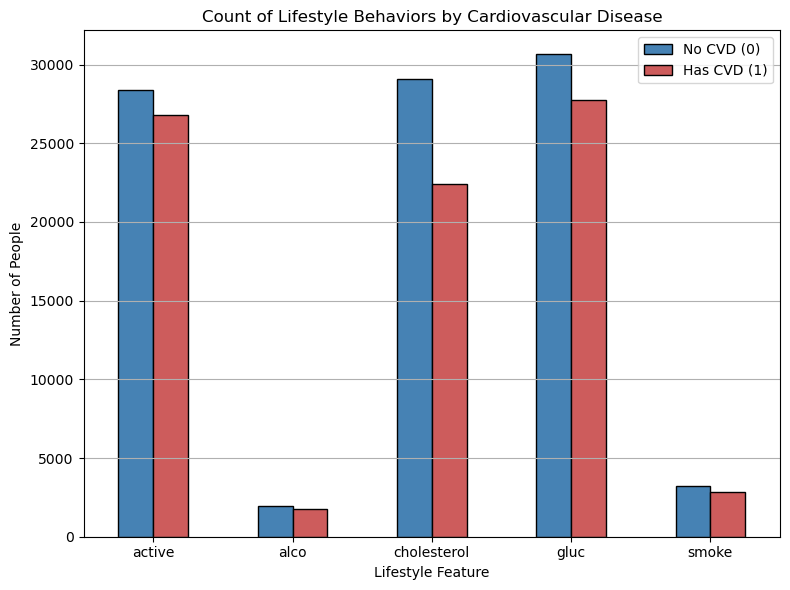

In [4]:

def plot_lifestyle_bars(df):
    
    features = ['smoke', 'alco', 'active', 'gluc', 'cholesterol']
    melted = df.melt(id_vars='cardio', value_vars=features, var_name='feature', value_name='value')

    # Filter only when value == 1 (i.e., they engage in the behavior)
    filtered = melted[melted['value'] == 1]

    # Count of people who engage in each behavior by cardio status
    count_df = filtered.groupby(['feature', 'cardio']).size().reset_index(name='count')

    # Pivot for easier plotting
    pivot_df = count_df.pivot(index='feature', columns='cardio', values='count').fillna(0)

    # Plot
    pivot_df.plot(kind='bar', figsize=(8, 6), color=['steelblue', 'indianred'], edgecolor='black')
    plt.title('Count of Lifestyle Behaviors by Cardiovascular Disease')
    plt.xlabel('Lifestyle Feature')
    plt.ylabel('Number of People')
    plt.xticks(rotation=0)
    plt.legend(['No CVD (0)', 'Has CVD (1)'])
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()
    
plot_lifestyle_bars(clean_heart_df)

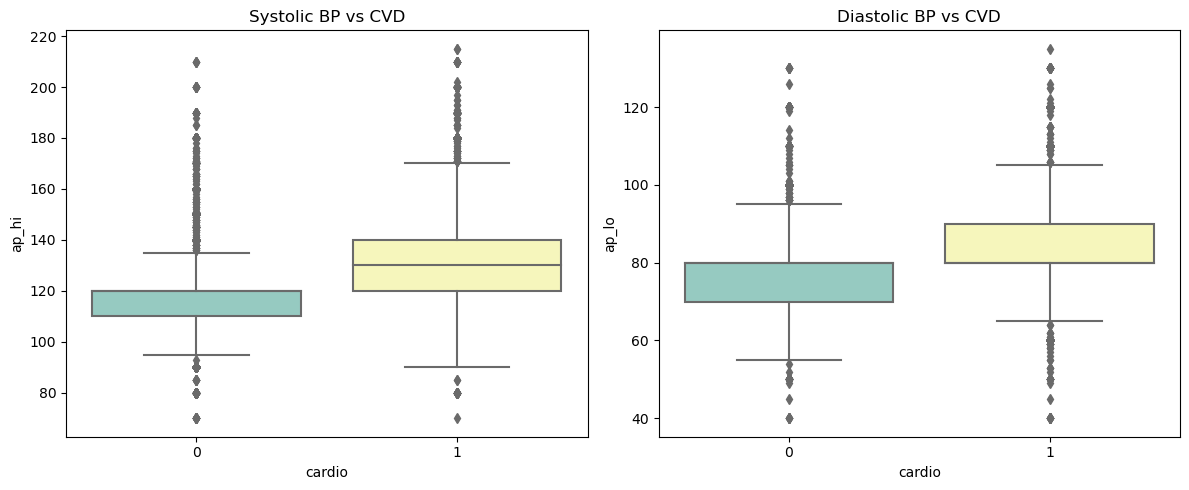

In [5]:
import seaborn as sns

def plot_blood_pressure_box(df):

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.boxplot(data=df, x='cardio', y='ap_hi', palette='Set3')
    
    plt.title('Systolic BP vs CVD')
    plt.subplot(1, 2, 2)
    
    sns.boxplot(data=df, x='cardio', y='ap_lo', palette='Set3')
    
    plt.title('Diastolic BP vs CVD')
    plt.tight_layout()
    plt.show()
    
plot_blood_pressure_box(clean_heart_df)

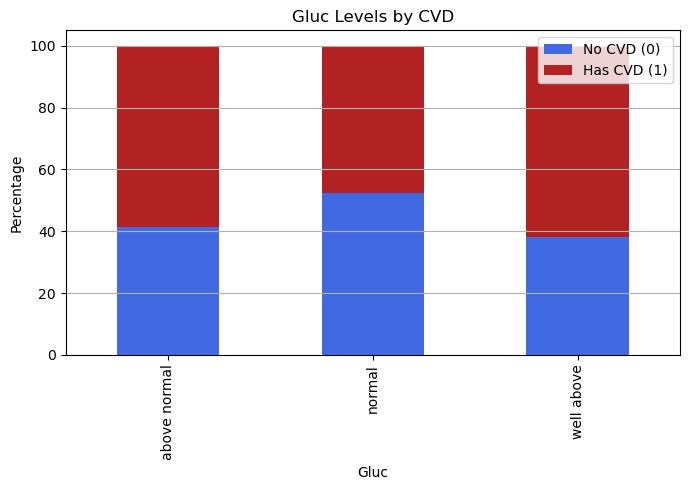

In [8]:
def plot_stacked_bar(df, feature, label_map):
    
    # Replace the numerical labels with descriptive labels
    df = df.copy()
    df[feature + '_label'] = df[feature].map(label_map)

    # Create cross-tab and normalize by row
    cross_tab = pd.crosstab(df[feature + '_label'], df['cardio'], normalize='index') * 100

    # Plot stacked bar chart
    cross_tab.plot(kind='bar', stacked=True, figsize=(7, 5), color=['royalblue', 'firebrick'])
    plt.title(f'{feature.capitalize()} Levels by CVD')
    plt.ylabel('Percentage')
    plt.xlabel(feature.capitalize())
    plt.legend(['No CVD (0)', 'Has CVD (1)'])
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()
    
plot_stacked_bar(clean_heart_df, 'gluc', MAP_NAMES)


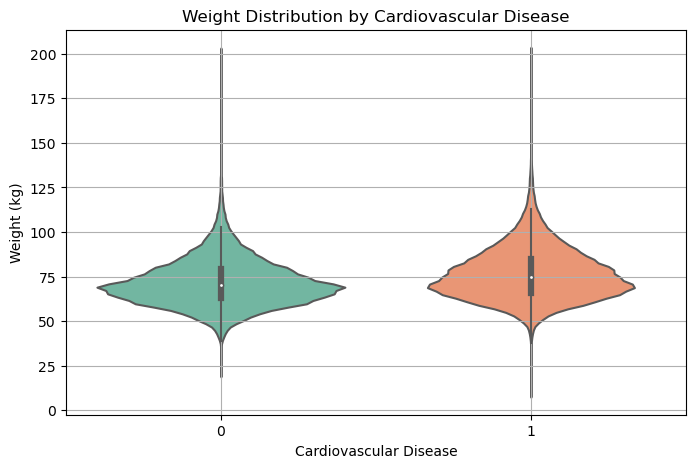

In [7]:
# Plot 6: Violin plot of weight
def plot_violin_weight(df):
    plt.figure(figsize=(8, 5))
    sns.violinplot(data=df, x='cardio', y='weight', palette='Set2')
    plt.title('Weight Distribution by Cardiovascular Disease')
    plt.xlabel('Cardiovascular Disease')
    plt.ylabel('Weight (kg)')
    plt.grid(True)
    plt.show()
    
plot_violin_weight(clean_heart_df)

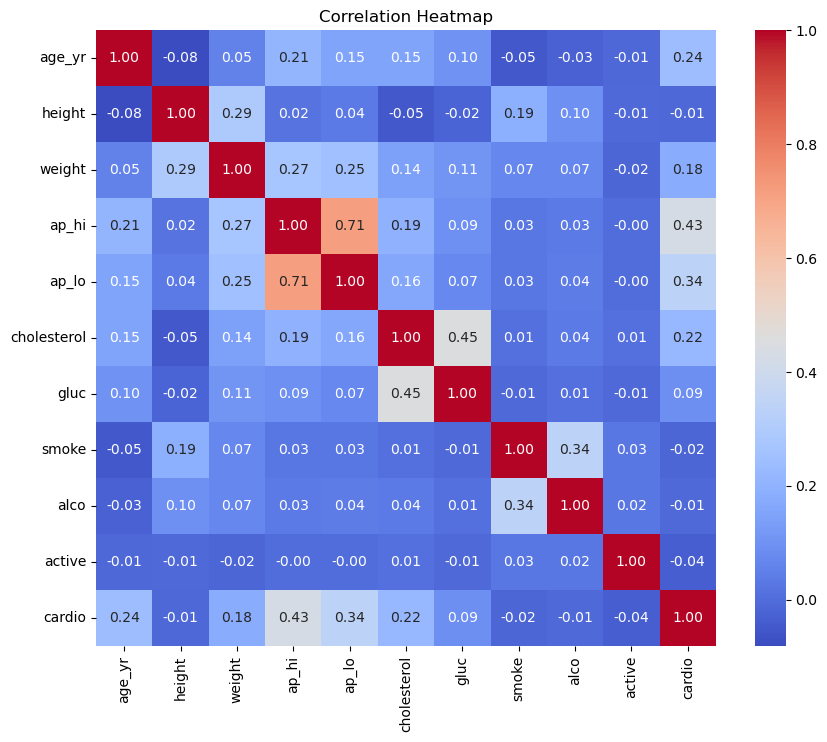

In [10]:
def plot_correlation_heatmap(df):
    plt.figure(figsize=(10, 8))
    corr = df[['age_yr', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap')
    plt.show()
    
plot_correlation_heatmap(clean_heart_df)